<a href="https://colab.research.google.com/github/UKJaagadhep/Data-science-and-machine-learning/blob/main/Variational%20Auto%20Encoder/VAE_(MNIST_DATA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam
import time

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0) #WE ONLY TAKE X_TRAIN AND X_TEST (INPUT IMAGES) BECAUSE WE ONLY NEED IMAGES FOR IMAGE GENERATION AND NOT THEIR LABELS
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11490434/11490434 [==============================] - 2s 0us/step


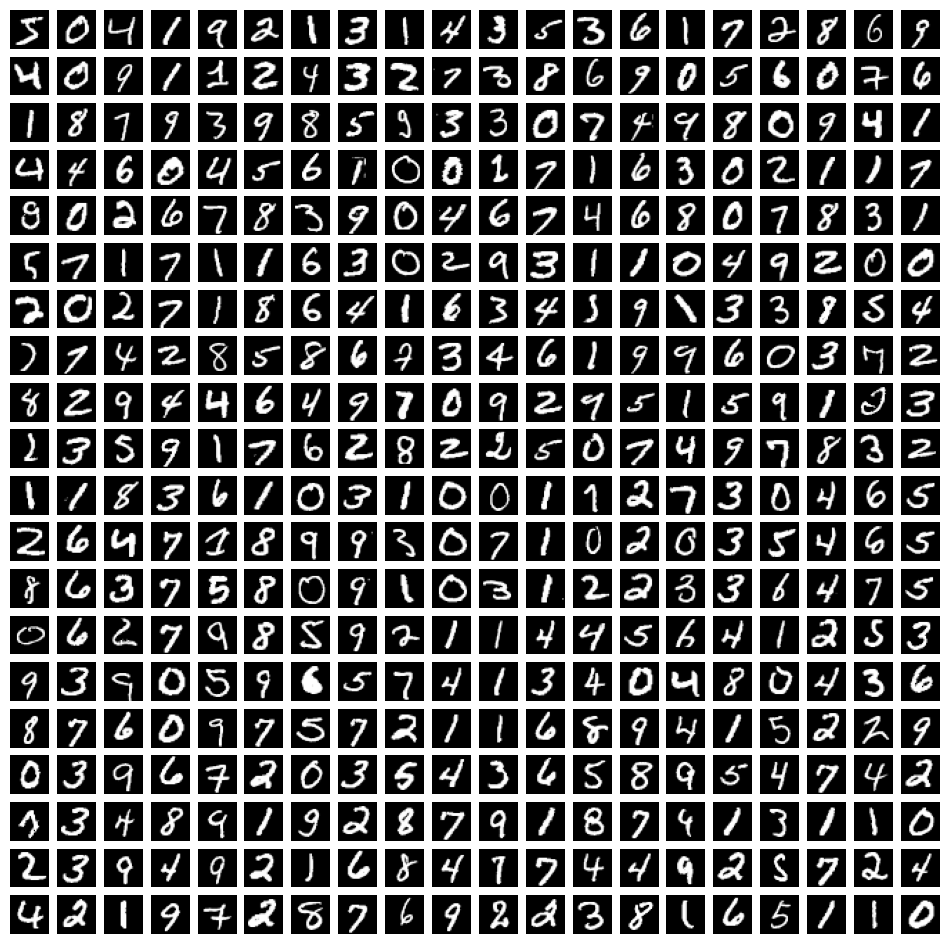

In [81]:
plt.figure(figsize = (12, 12))
k = 0
for i in x_train[:400]:
    ax = plt.subplot(20, 20 ,k+1)
    plt.imshow(i,cmap = "Greys_r")
    plt.axis('off')
    k += 1

In [3]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [4]:
len(dataset)

70000

In [41]:
batch_size = 128
latent_dimension = 2

In [42]:
train_dataset = (
    dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [43]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

SO ALL IMAGES ARE (28, 28, 1)

1 BECAUSE GRAYSCALE COLOR FORMAT

# **MODEL**

## **SAMPLING LAYER**

In [44]:
class Sampling(Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return mean + tf.math.exp(0.5*log_var) * tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))

## **ENCODER**

In [45]:
encoder_inputs = Input(shape=(28,28,1))

x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)

mean = Dense(latent_dimension)(x)
log_var = Dense(latent_dimension)(x)

z = Sampling()([mean,log_var])

encoder_model = Model(encoder_inputs,[z,mean,log_var], name='encoder')
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 14, 14, 32)           320       ['input_5[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d_4[0][0]']            
                                                                                                  
 flatten_2 (Flatten)         (None, 3136)                 0         ['conv2d_5[0][0]']            
                                                                                            

## **DECODER**

In [46]:
latent_inputs = Input(shape = (latent_dimension))

x = Dense(7 * 7 * 64, activation = 'relu')(latent_inputs)
x = Reshape((7, 7, 64))(x)

x = Conv2DTranspose(64, 3, activation = 'relu', strides = 2, padding = 'same')(x)
x = Conv2DTranspose(32, 3, activation = 'relu', strides = 2, padding = 'same')(x)

decoder_output = Conv2DTranspose(1, 3, activation = 'sigmoid', padding = 'same')(x)
decoder_model = Model(latent_inputs,decoder_output,name = 'decoder')
decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_11 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 28, 28, 1)         289 

# **VAE MODEL**

In [47]:
vae_input = Input(shape = (28, 28, 1), name = "vae_input")
z, mean, log_var = encoder_model(vae_input)
output = decoder_model(z)
vae = Model(vae_input, output, name = "vae")
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vae_input (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134165 (524.08 KB)
Trainable params: 134165 (524.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **TRAINING**

In [48]:
optimizer = Adam(learning_rate = 1e-3)
epochs = 20

## **LOSS FUNCTION**

In [49]:
def custom_loss(y_true, y_pred, mean, log_var):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis = (1, 2)))

  regularization_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var)), axis = 1))

  return reconstruction_loss + regularization_loss

## **CUSTOM TAINING LOOP**

In [50]:
@tf.function
def training_block(x_batch):
  with tf.GradientTape() as recorder:
    z, mean, log_var = encoder_model(x_batch)
    y_pred = decoder_model(z)
    y_true = x_batch
    loss = custom_loss(y_true, y_pred, mean, log_var)

  partial_derivatives = recorder.gradient(loss, vae.trainable_weights)
  optimizer.apply_gradients(zip(partial_derivatives, vae.trainable_weights))
  return loss

## **MODEL TRAINING**

In [51]:
def image_generation(epochs):
  for epoch in range(1,epochs+1):
    print('Training starts for epoch number {}'.format(epoch))
    time_1 = time.time()
    for step, x_batch in enumerate(train_dataset):
      loss = training_block(x_batch)
    print(time.time() - time_1)
    print('Training Loss is: ', loss)
  print('Training Complete!!!')

In [52]:
model_custom_train = image_generation(epochs)

Training starts for epoch number 1
7.59489107131958
Training Loss is:  tf.Tensor(177.52806, shape=(), dtype=float32)
Training starts for epoch number 2
3.103325843811035
Training Loss is:  tf.Tensor(157.96468, shape=(), dtype=float32)
Training starts for epoch number 3
3.2277908325195312
Training Loss is:  tf.Tensor(161.38594, shape=(), dtype=float32)
Training starts for epoch number 4
3.209064483642578
Training Loss is:  tf.Tensor(165.77159, shape=(), dtype=float32)
Training starts for epoch number 5
3.1611645221710205
Training Loss is:  tf.Tensor(149.08662, shape=(), dtype=float32)
Training starts for epoch number 6
3.172419548034668
Training Loss is:  tf.Tensor(157.46031, shape=(), dtype=float32)
Training starts for epoch number 7
3.339493751525879
Training Loss is:  tf.Tensor(155.8754, shape=(), dtype=float32)
Training starts for epoch number 8
3.2025904655456543
Training Loss is:  tf.Tensor(151.72601, shape=(), dtype=float32)
Training starts for epoch number 9
3.1952779293060303
T

In [53]:
class VAE(tf.keras.Model):
  def __init__(self, encoder_model, decoder_model):
    super(VAE, self).__init__()
    self.encoder = encoder_model
    self.decoder = decoder_model
    self.loss_tracker = tf.keras.metrics.Mean(name = 'loss')
  @property
  def metrics(self):
    return [self.loss_tracker]

  def train_step(self,x_batch):
    with tf.GradientTape() as recorder:
      z, mean, log_var = encoder_model(x_batch)
      y_pred = decoder_model(z)
      y_true = x_batch
      loss = custom_loss(y_true, y_pred, mean, log_var)

    partial_derivatives = recorder.gradient(loss, self.trainable_weights)
    optimizer.apply_gradients(zip(partial_derivatives, self.trainable_weights))

    self.loss_tracker.update_state(loss)
    return {'loss' : self.loss_tracker.result()}

In [54]:
model = VAE(encoder_model, decoder_model)
model.compile(optimizer = optimizer)
model.fit(train_dataset, epochs = 20,batch_size = 128)

Epoch 1/20
547/547 [==============================] - 7s 9ms/step - loss: 150.6728
Epoch 2/20
547/547 [==============================] - 5s 8ms/step - loss: 150.4733
Epoch 3/20
547/547 [==============================] - 5s 8ms/step - loss: 150.2751
Epoch 4/20
547/547 [==============================] - 5s 9ms/step - loss: 150.1716
Epoch 5/20
547/547 [==============================] - 5s 8ms/step - loss: 149.8929
Epoch 6/20
547/547 [==============================] - 5s 9ms/step - loss: 149.7653
Epoch 7/20
547/547 [==============================] - 5s 8ms/step - loss: 149.6951
Epoch 8/20
547/547 [==============================] - 5s 9ms/step - loss: 149.5006
Epoch 9/20
547/547 [==============================] - 5s 9ms/step - loss: 149.3653
Epoch 10/20
547/547 [==============================] - 5s 8ms/step - loss: 149.2043
Epoch 11/20
547/547 [==============================] - 5s 9ms/step - loss: 149.0579
Epoch 12/20
547/547 [==============================] - 5s 8ms/step - loss: 148.9737
E

# **IMAGE GENERATION**

In [66]:
scale = 1
n = 20

In [67]:
np.linspace(2, 5, num = 6)

array([2. , 2.6, 3.2, 3.8, 4.4, 5. ])

In [68]:
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)

In [69]:
print(grid_x)

[-1.         -0.89473684 -0.78947368 -0.68421053 -0.57894737 -0.47368421
 -0.36842105 -0.26315789 -0.15789474 -0.05263158  0.05263158  0.15789474
  0.26315789  0.36842105  0.47368421  0.57894737  0.68421053  0.78947368
  0.89473684  1.        ]


In [70]:
print(grid_y)

[-1.         -0.89473684 -0.78947368 -0.68421053 -0.57894737 -0.47368421
 -0.36842105 -0.26315789 -0.15789474 -0.05263158  0.05263158  0.15789474
  0.26315789  0.36842105  0.47368421  0.57894737  0.68421053  0.78947368
  0.89473684  1.        ]


1/1 [==============================] - 0s 18ms/step


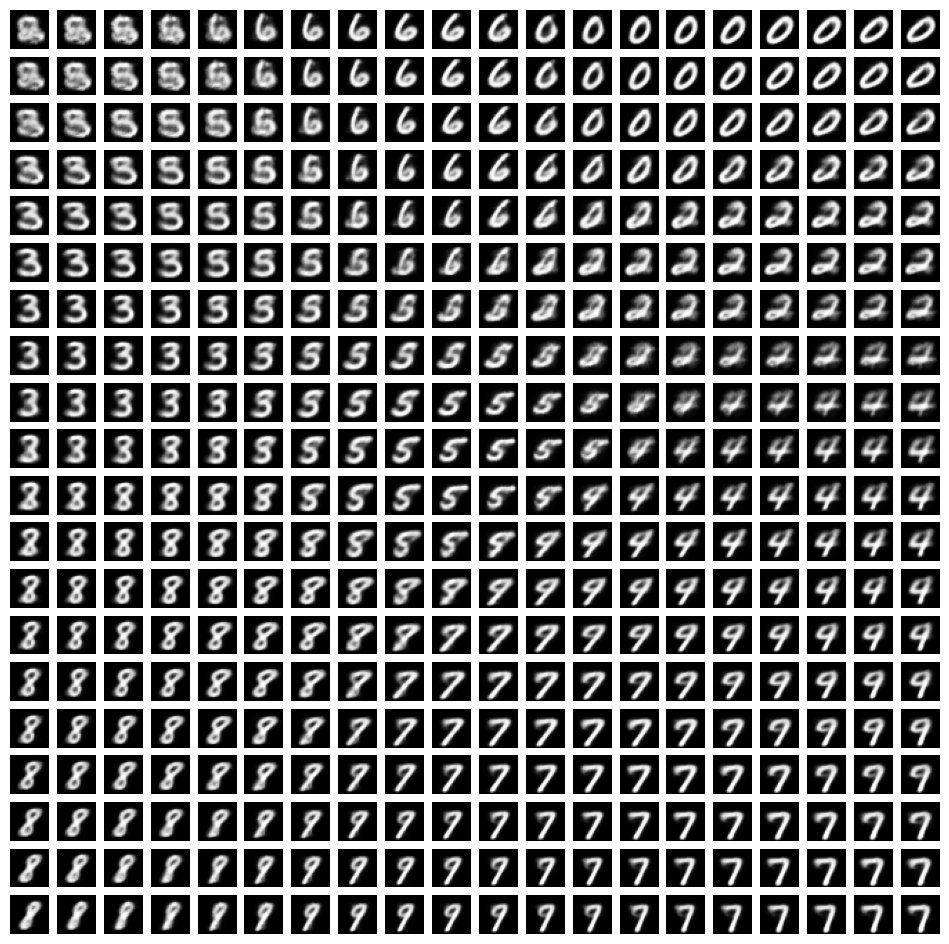

In [73]:
plt.figure(figsize = (12, 12))
k = 0
for i in grid_x:
  for j in grid_y:
    ax = plt.subplot(n, n ,k+1)

    input = tf.constant([[i,j]])
    out = model.decoder.predict(input)[0][...,0]
    plt.imshow(out,cmap = "Greys_r")
    plt.axis('off')
    k += 1

In [74]:
print(vae.layers[2].predict(tf.constant([[-1,1]]))[0][...,0].shape)

1/1 [==============================] - 0s 179ms/step
(28, 28)


# **LATENT SPACE VISUALIZATION**

## **VISUALIZING Z FOR EACH NUMBER**

In [75]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
mnist_digits = np.expand_dims(x_train,-1).astype("float32") / 255

1875/1875 [==============================] - 4s 2ms/step


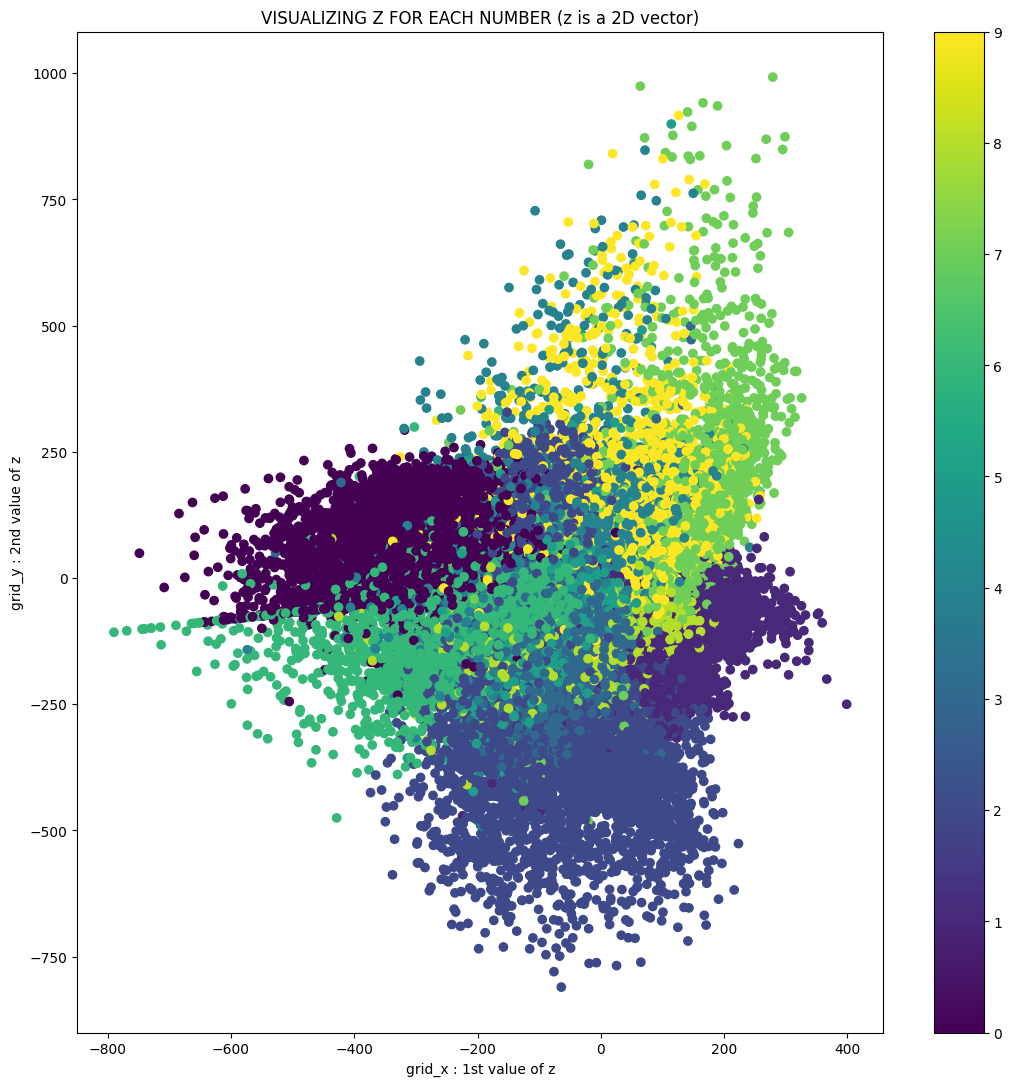

In [83]:
z, mean, log_var = vae.layers[1].predict(x_train)
plt.figure(figsize = (13, 13))
plt.scatter(z[:,0],z[:,1],c = y_train)
plt.colorbar()
plt.title('VISUALIZING Z FOR EACH NUMBER (z is a 2D vector)')
plt.xlabel('grid_x : 1st value of z')
plt.ylabel('grid_y : 2nd value of z')
plt.show()